# Проект 3. Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости.    

Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.     

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

### Шаг 1. Изучение общей информации:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t', decimal = '.')
df.info()
pd.set_option('display.max_columns', None)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Предварительные выводы:

Всего таблице содержится  23699 строки.   

Замечаю, что столбец 'is_apartment' содержит большое количество пропусков. По всей видимости, это не являлось обязательным полем для заполнения, и пользователи пропускали его, либо не понимали что значит "Апартаменты".
Логично было бы все пропуски заполнить 'False'.   

Также отмечу, что данные, полученные автоматически (на основе картографических данных), имеют достаточно много пропусков.   
Скорее всего, это связано с тем, что программа не обладает высокой точностью в определении расстояния и обладает еще меньшей точностью в распознавании прудов и парков.    
Либо это возможно, если не определено расстояние до центра, а значит и остальные данные будут пустыми.

### Шаг 2. Предобработка данных

### Удаление пропусков 

Начну предобработку с потолков (столбец 'ceiling_height').

In [2]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Этот столбец содержит достаточно большое кол-во пропусков (примерно 31%).      

Заполню пропущенные значения медианой, т.к. она наименее чувствительна к выбросам.   
Думаю, причиной пропусков является тот факт, что, возможно, продавцы недвижимости не знают точную высоту потолков и пропускают эту строку. 

Также замечаю, что min = 1, max = 100. Похоже, что это выбросы.    
Возможно, выбросы могут быть связаны с человеческой или технической ошибкой, например, неправильный ввод данных, некорректные единицы измерения и т.п.  

In [3]:
print('Пропуски в living_area до обработки:', df['living_area'].isna().sum())
print('Пропуски в ceiling_height до обработки:', df['ceiling_height'].isna().sum())
df.loc[df['ceiling_height'].isnull(),'ceiling_height'] = df['ceiling_height'].median()
print('Пропуски в living_area после обработки:', df['living_area'].isna().sum())
print('Пропуски в ceiling_height после обработки:', df['ceiling_height'].isna().sum())

Пропуски в living_area до обработки: 1903
Пропуски в ceiling_height до обработки: 9195
Пропуски в living_area после обработки: 1903
Пропуски в ceiling_height после обработки: 0


Жилая прощадь является важным компонентом, который образует цену, поэтому пустые значения я удалю.

In [4]:
print('Пропуски в living_area до обработки:', df['living_area'].isna().sum())
df.dropna(subset = ['living_area'], inplace=True)
print('Пропуски в living_area после обработки .dropna():', df['living_area'].isna().sum())

Пропуски в living_area до обработки: 1903
Пропуски в living_area после обработки .dropna(): 0


С кухнями поступлю аналогично:

In [5]:
print('Пропуски в kitchen_area до обработки:', df['kitchen_area'].isna().sum())
df.dropna(subset = ['kitchen_area'], inplace = True)
print('Пропуски в kitchen_area после обработки .dropna():', df['kitchen_area'].isna().sum())

Пропуски в kitchen_area до обработки: 814
Пропуски в kitchen_area после обработки .dropna(): 0


Заменю пропуски в 'is_apartment' на 'False', поскольку это не является важным фактором.    
Судя по всему, владелец не вводил эти данные, следовательно, скорее всего, это не апартаменты.

In [6]:
df.loc[df['is_apartment'].isna(),'is_apartment'] = False
print('Пропуски в is_apartment после обработки:', df['is_apartment'].isna().sum())

Пропуски в is_apartment после обработки: 0


Теперь столбец 'balcony'. Если указано пустое значение, то, скорее всего, балкона нет, поэтому проставлю просто 0.

In [7]:
df.loc[df['balcony'].isnull(),'balcony'] = 0
print('Пропуски в balcony после обработки:', df['balcony'].isna().sum())

Пропуски в balcony после обработки: 0


Перейду теперь к данным, заполненным автоматически.    
Просмотрю строки с пустым значением столбца 'cityCenters_nearest' - 'Расстояние до центра':

In [8]:
df[df['cityCenters_nearest'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.40,5,False,False,False,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,False,False,False,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.65,5.0,30.00,5,False,False,False,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,False,False,False,11.00,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
38,10,3150000.0,40.00,2018-03-29T00:00:00,1,2.75,18.0,16.30,9,False,False,False,11.60,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,103.0


Посмотрю, может быть, их можно заполнить медианой по городу:

In [9]:
print('Значения, которые присутствуют в cityCenters_nearest:', df[df['locality_name'] == 'посёлок Мурино']
      ['cityCenters_nearest'].unique(),'\n\n')
sd=df[df['locality_name'] == 'деревня Кудрово'].head()

Значения, которые присутствуют в cityCenters_nearest: [nan] 




Вижу результат выполнения программы - [nan].   
Думаю, что это какой-то сбой программы, поскольку некоторые населенные пункты просто не получается просчитать.    
В данной работы мы не учитываем этот фактор при анализе, поэтому удалять такие данные не буду.

In [10]:
df.info() #перепроверю

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20982 entries, 0 to 23698
Data columns (total 22 columns):
total_images            20982 non-null int64
last_price              20982 non-null float64
total_area              20982 non-null float64
first_day_exposition    20982 non-null object
rooms                   20982 non-null int64
ceiling_height          20982 non-null float64
floors_total            20943 non-null float64
living_area             20982 non-null float64
floor                   20982 non-null int64
is_apartment            20982 non-null bool
studio                  20982 non-null bool
open_plan               20982 non-null bool
kitchen_area            20982 non-null float64
balcony                 20982 non-null float64
locality_name           20943 non-null object
airports_nearest        16308 non-null float64
cityCenters_nearest     16329 non-null float64
parks_around3000        16330 non-null float64
parks_nearest           7266 non-null float64
ponds_around3000

Удалим строки без названия населенного пункта (хорошо, что их всего около 30):

In [11]:
df.dropna(subset = ['locality_name'], inplace = True)

Убедимся, что нет дупликатов:

In [12]:
print(df.duplicated().sum())

0


### Изменение типов данных

Думаю, остальные данные можно не трогать, поэтому займусь изменением типов данных.    
Для начала переведу большинство float64 в int64 для зрительного удобства.    
Оставлю только 'total_area', 'ceiling_height', 'floors_total', 'living_area', 'kitchen_area'. 

In [13]:
columns_name = ['balcony','last_price','floors_total','days_exposition','ponds_nearest','ponds_around3000',
             'parks_nearest','cityCenters_nearest','airports_nearest']
def func_to_int(data, name):
    data[name] = data.loc[data[name].notna(),name].astype('Int32', errors='ignore')
    return data
for row in columns_name:
    df = func_to_int(df,row)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1.0,482,2,755,NaN
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1.0,90,2,574,558.0
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0
5,10,2890000,30.4,2018-09-10T00:00:00,1,2.65,12,14.4,5,False,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0


Поменяю тип столбца 'first_day_exposition' в 'datetime64' и посмотрю общую информацию о данных после обработки.

In [14]:
df['first_day_exposition'] = df['first_day_exposition'].astype('datetime64')

In [15]:
print(df.info())
df_to_end = df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20943 entries, 0 to 23698
Data columns (total 22 columns):
total_images            20943 non-null int64
last_price              20943 non-null Int32
total_area              20943 non-null float64
first_day_exposition    20943 non-null datetime64[ns]
rooms                   20943 non-null int64
ceiling_height          20943 non-null float64
floors_total            20905 non-null Int32
living_area             20943 non-null float64
floor                   20943 non-null int64
is_apartment            20943 non-null bool
studio                  20943 non-null bool
open_plan               20943 non-null bool
kitchen_area            20943 non-null float64
balcony                 20943 non-null Int32
locality_name           20943 non-null object
airports_nearest        16275 non-null Int32
cityCenters_nearest     16296 non-null Int32
parks_around3000        16297 non-null float64
parks_nearest           7252 non-null Int32
ponds_around3000    

Теперь данные готовы для дальнейшего анализа.

### Шаг 3. Расчёты и добавление столбцов в таблицу

Добавлю в таблицу для дальнейшего анализа:   
а) цену квадратного метра;   
б) день недели, месяц и год публикации объявления;     
в) этаж квартиры (первый, последний, другой);      
г) соотношение жилой и общей площади, а также отношение площади кухни к общей.   

In [16]:
df['price_per_meter'] = df['last_price'] / df['total_area']
df['day_of_week'] = pd.DatetimeIndex(df['first_day_exposition']).day
df['day_of_week_name'] = df['first_day_exposition'].dt.weekday_name
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year
df.head() #проверю

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week,day_of_week_name,month,year
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1.0,482,2,755,NaN,120370.370370,7,Thursday,3,2019
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0,82920.792079,4,Tuesday,12,2018
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1.0,90,2,574,558.0,92785.714286,20,Thursday,8,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0,100000.000000,19,Tuesday,6,2018
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474,10,Monday,9,2018


Напишу функцию для определения этажа квартиры:

In [17]:
def find_floor(line):
    total_floors = line['floors_total']
    floor = line['floor']
    if floor == total_floors:
        return 'Последний'
    elif floor == 1:
        return 'Первый'
    else:
        return 'Другой'
df['floor_type'] = df.apply(find_floor, axis=1)
df['floor_type'].unique()

array(['Другой', 'Первый', 'Последний'], dtype=object)

Добавлю последние два столбца:
1) соотношение жилой площади к общей;    
2) отношение площади кухни к общей.

In [18]:
df['living_to_total'] = df['living_area'] / df['total_area']
df['kitchen_to_total'] = df['kitchen_area'] / df['total_area']
df.head() #проверю

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week,day_of_week_name,month,year,floor_type,living_to_total,kitchen_to_total
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1.0,482,2,755,NaN,120370.370370,7,Thursday,3,2019,Другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0,82920.792079,4,Tuesday,12,2018,Первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1.0,90,2,574,558.0,92785.714286,20,Thursday,8,2015,Другой,0.612500,0.148214
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0,100000.000000,19,Tuesday,6,2018,Другой,0.320000,0.410000
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474,10,Monday,9,2018,Другой,0.473684,0.299342


Датафрейм готов к проведению исследования.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции.

Изучю некоторые параметры датафрейма и построю для них гистограммы.    
Начну с площади:

1 ) Площадь
count    20943.000000
mean        60.532519
std         34.509672
min         14.000000
25%         40.500000
50%         52.200000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64


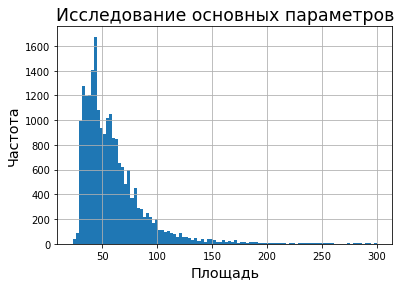

2 ) Цена
count    2.094300e+04
mean     6.506516e+06
std      9.599618e+06
min      1.219000e+04
25%      3.500000e+06
50%      4.700000e+06
75%      6.800000e+06
max      4.200000e+08
Name: last_price, dtype: float64


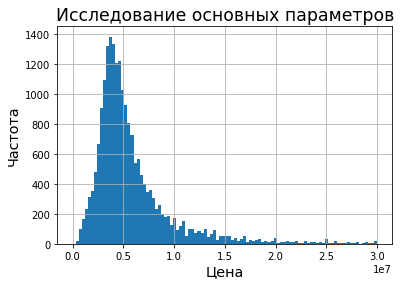

3 ) Количество комнат
count    20943.000000
mean         2.095402
std          1.064696
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


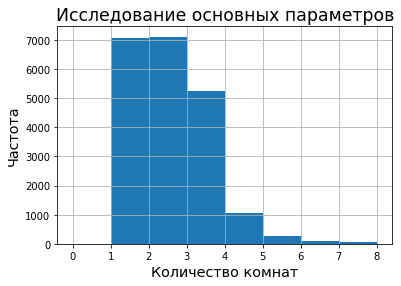

4 ) Высота потолков
count    20943.000000
mean         2.723064
std          0.995772
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64


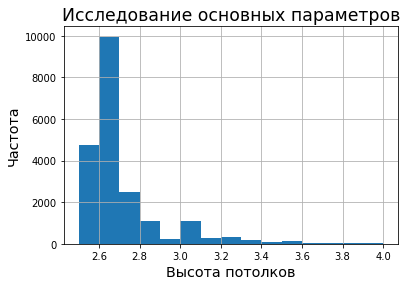

In [19]:
df_names = ['total_area','last_price','rooms','ceiling_height']
df_bins = [100, 100, 8, 15]
df_ranges = [(23,300), (0,30*10**6), (0,8), (2.5,4)]
df_xlabel = ['Площадь', 'Цена', 'Количество комнат', 'Высота потолков']
i = 0
for row in df_names:
    print(i+1,')', df_xlabel[i])
    total_area_df = df[row].hist(bins=df_bins[i], range=df_ranges[i]);
    print(df[row].describe())
    plt.xlabel(df_xlabel[i], fontsize='x-large')
    plt.ylabel("Частота", fontsize='x-large')
    plt.title("Исследование основных параметров", fontsize='xx-large')
    plt.show()
    i+=1

### Комментарии:
**1) Площадь**    
14 кв.м - слишком маленькое значение для площади квартиры. Вероятно, что это техническая или человеческая ошибка.   
Несмотря на чересчур большое значение площади в 900 кв.м, удалять эти значения я не буду, поскольку, как оказалось, такие квартиры есть. Эти выбросы я обработаю позже.    
Видно, что основная масса объявлений находится в районе 50 кв. м.    

**2) Цена**    
Из гистограммы видно, что основная масса цен находится в пределах до 5 млн рублей, но также здесь есть выбросы, например, минимальная цена - 12000 рублей. Эти выбросы я обработаю позже.      

**3) Количество комнат**    
Максимальное значение в 19 комнат выглядит крайне странно. Из гистограммы видно, что основная масса комнат - до 4, поэтому остановлюсь на 8 комнатах.

**4) Высота потолков**    
Потолки в 1 метр и 100 являюся явными выбросами, поэтому не стоит их учитывать их в гистограмме.    
Основная высота потолков около 2.6 метров, но есть и значения больше, которые нужно учесть.  


**Видно, что гистограммы напоминают распределение Пуассона - это хороший знак :)**

### Изучение времени продажи квартир

Для начала рассчитаю среднее и медиану:

In [20]:
print('Среднее время продажи:', df['days_exposition'].mean())
print('Медиана времени продажи:', df['days_exposition'].median())

Среднее время продажи: 185.52595136542402
Медиана времени продажи: 102.0


Видно, что среднее практически вдвое больше медианы. Предположу, что на это оказало влияние особенно "долгих", непривлекательных объявлений.   
Просмотрю общую информацию:

In [21]:
df['days_exposition'].describe()

count    18053.000000
mean       185.525951
std        222.002600
min          1.000000
25%         45.000000
50%        102.000000
75%        239.000000
max       1580.000000
Name: days_exposition, dtype: float64

Первый квартиль Q1 равен 42 дням - на редкость быстрая (хотя и вполне реальная!) продажа для недвижимости.   
Третий квартиль Q3 равен примерно 238 дням - 8 месяцев.   
Построю гистограмму и диаграмму размаха:

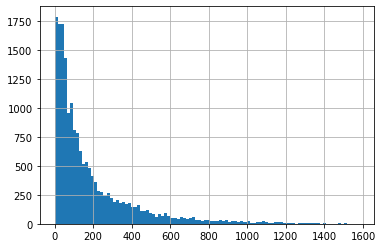

(0, 600)

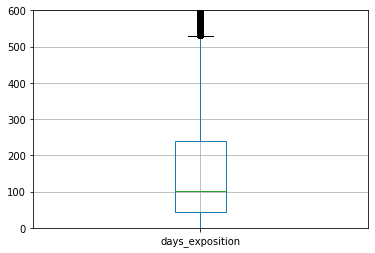

In [22]:
df['days_exposition'].hist(bins=100)
plt.show()
df.boxplot(column='days_exposition')
plt.ylim(0,600)

Положим, что продажа прошла **_очень быстро_**, если она заняла меньше 40 дней.    
Если же она длилась больше 550 дней, то это **_необычно долго_**.        

Причинами таких аномалий, полагаю, являются установка чересчур завышенной, необоснованной цены, либо указание в объявлении некорректных данных.   
Создам новую таблицу, без выбросов, учитывая аномальные значения, полученные ранее:

In [23]:
df_new = df.query('days_exposition < 550 and ceiling_height > 2.5 and ceiling_height < 4 and rooms < 10\
and last_price > 500000 and total_area > 17')
df_new.head()
#df_new.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week,day_of_week_name,month,year,floor_type,living_to_total,kitchen_to_total
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.60,1,False,False,False,11.00,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0,82920.792079,4,Tuesday,12,2018,Первый,0.460396,0.272277
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0,100000.000000,19,Tuesday,6,2018,Другой,0.320000,0.410000
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.40,5,False,False,False,9.10,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474,10,Monday,9,2018,Другой,0.473684,0.299342
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.60,6,False,False,False,14.40,1,посёлок Парголово,52996,19143,0.0,NaN,0,NaN,155.0,99195.710456,2,Thursday,11,2017,Другой,0.284182,0.386059
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.43,26,False,False,False,8.81,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,87454.764777,23,Wednesday,5,2018,Другой,0.465320,0.265682


Построю графики зависимости цены от площади квартиры, количества комнат, удаленности от центра, а также рассчитаю коэффициент Пирсона.<a name="1"></a>

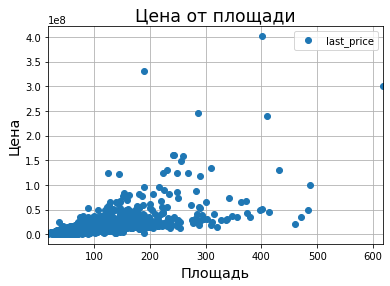

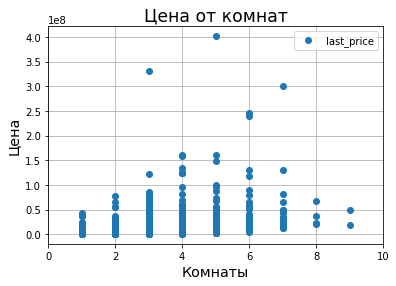

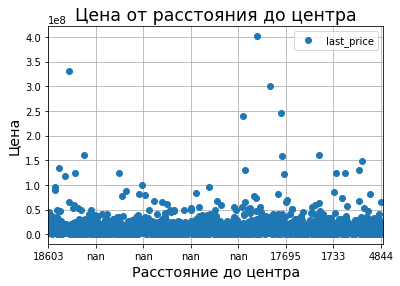

In [24]:
df_new_names = ['total_area', 'rooms', 'cityCenters_nearest']
df_new_titles = ['Цена от площади', 'Цена от комнат', 'Цена от расстояния до центра']
df_new_xlabel = ["Площадь", "Комнаты", "Расстояние до центра"]
df_new_end = []
i=0
for row in df_new_names:   
    k=df_new.plot(x = row, y = 'last_price', style='o', grid=True)
    if row == 'rooms':
        plt.xlim(0,10)
    plt.xlabel(df_new_xlabel[i], fontsize = 'x-large')
    plt.ylabel('Цена', fontsize = 'x-large')
    plt.title(df_new_titles[i], fontsize = 'xx-large')
    df_new_end.append(k)
    plt.show()
    i+=1

In [25]:
df_for_corr = df_new.loc[:,['last_price', 'total_area', 'rooms', 'cityCenters_nearest']]
df_for_corr.corr()

,last_price,total_area,rooms,cityCenters_nearest
last_price,1.000000,0.660929,0.381952,-0.220050
total_area,0.660929,1.000000,0.778199,-0.224388
rooms,0.381952,0.778199,1.000000,-0.196932
cityCenters_nearest,-0.220050,-0.224388,-0.196932,1.000000


Исходя из данных видно, что цена сильно зависит от площади квартиры (положительный коэффициент Пирсона). Цена меньше зависит от числа комнат. От удаленности от центра зависит не так сильно, но при увеличении расстояния цена уменьшается.  

Рассмотрю теперь зависимость от этажа: рассчитаю медиану для каждого и построю график.

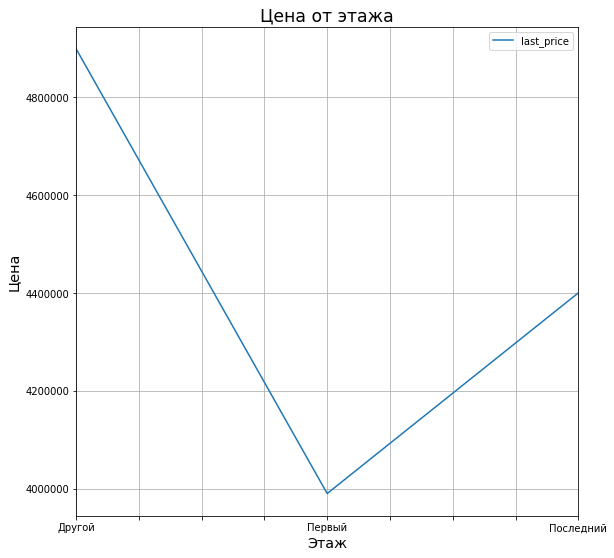

In [26]:
df_floor = df_new.pivot_table(index = 'floor_type', values = 'last_price', aggfunc = 'median')
df_floor.plot(grid = True, figsize = (9,9));
plt.title('Цена от этажа',fontsize = 'xx-large')
plt.xlabel('Этаж',fontsize = 'x-large')
plt.ylabel('Цена',fontsize = 'x-large')
plt.show()

Видно, что на первом этаже квартиры стоят дешевле, чем на "Других" этажах.

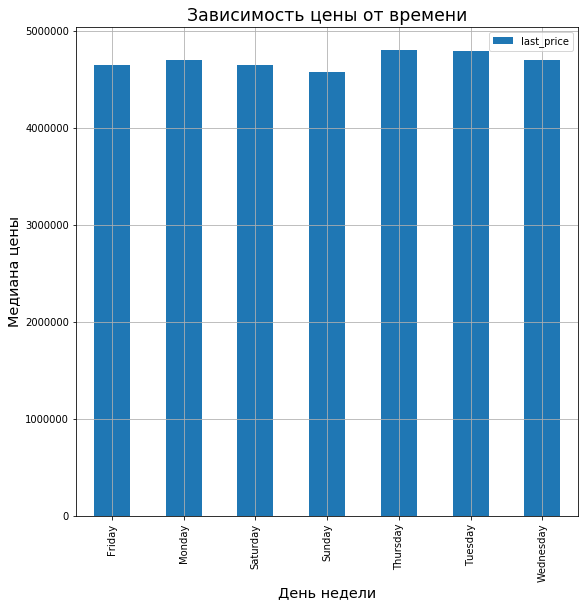

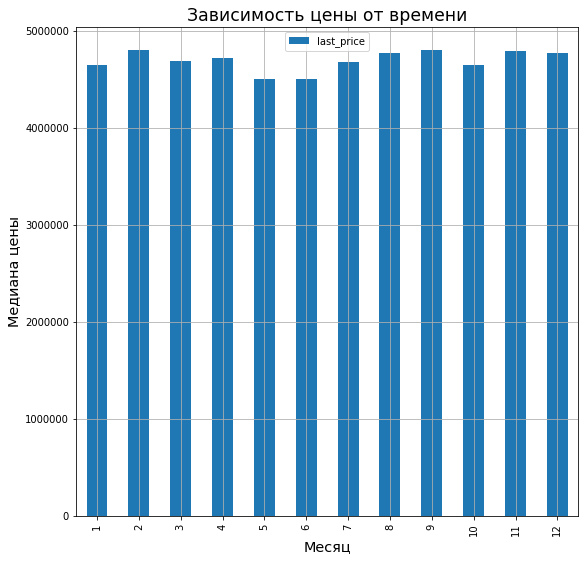

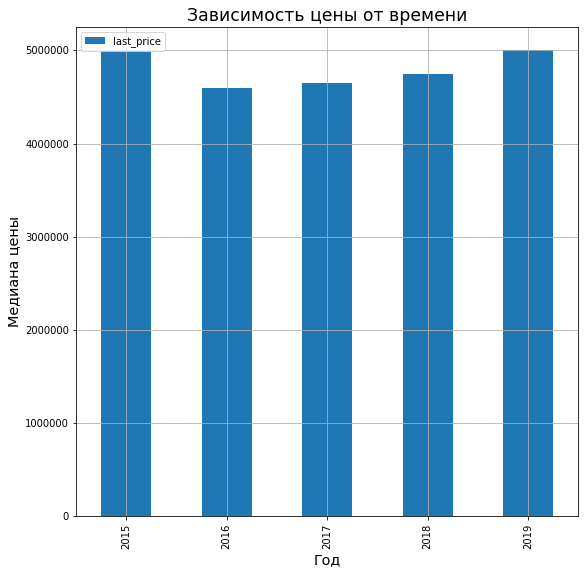

In [27]:
df_new_columns = ['day_of_week_name','month','year']
df_new_date_analysis = []
xlabels = ['День недели','Месяц','Год']
i = 0
for row in df_new_columns:
    df_new_cycle = df_new.pivot_table(index = row, values = 'last_price', aggfunc = 'median')
    k = df_new_cycle.plot(kind = 'bar', grid = True, figsize = (9,9));
    plt.xlabel(xlabels[i],fontsize = 'x-large')
    plt.ylabel('Медиана цены', fontsize = 'x-large')
    plt.title('Зависимость цены от времени', fontsize = 'xx-large')
    df_new_date_analysis.append(k)
    i += 1

Из графиков можно сделать следующие выводы:  
1) цена не зависит от дня публикации объявления;  
2) можно заметить разницу между мартом и маем, но несильную => месяц тоже не влияет;  
3) в последние два года наблюдается рост => цена зависит от года (= экономической ситуации в стране).

### Наиболее популярные населенные пункты

In [28]:
top_ten = df_new.groupby('locality_name').count().sort_values('last_price', ascending = False).head(10).index
top_ten_data = (df_new.loc[df_new['locality_name'].isin(top_ten)])
print('Наибольшее количество объявлений', top_ten)

Наибольшее количество объявлений Index(['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск',
       'посёлок Парголово', 'деревня Кудрово', 'Колпино', 'Пушкин', 'Гатчина',
       'Петергоф'],
      dtype='object', name='locality_name')


In [29]:
top_ten_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week,day_of_week_name,month,year,floor_type,living_to_total,kitchen_to_total
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.60,1,False,False,False,11.00,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0,82920.792079,4,Tuesday,12,2018,Первый,0.460396,0.272277
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0,100000.000000,19,Tuesday,6,2018,Другой,0.320000,0.410000
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.60,6,False,False,False,14.40,1,посёлок Парголово,52996,19143,0.0,NaN,0,NaN,155.0,99195.710456,2,Thursday,11,2017,Другой,0.284182,0.386059
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.43,26,False,False,False,8.81,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,87454.764777,23,Wednesday,5,2018,Другой,0.465320,0.265682
10,5,5050000,39.60,2017-11-16,1,2.67,12,20.30,3,False,False,False,8.50,0,Санкт-Петербург,38357,13878,1.0,310,2,553,137.0,127525.252525,16,Thursday,11,2017,Другой,0.512626,0.214646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23688,19,9200000,101.00,2019-04-01,3,3.05,15,63.00,12,False,False,False,15.00,0,Санкт-Петербург,15632,14428,0.0,NaN,0,NaN,23.0,91089.108911,1,Monday,4,2019,Другой,0.623762,0.148515
23689,13,3550000,35.30,2018-02-28,1,2.86,15,16.30,4,False,False,False,9.10,2,Санкт-Петербург,17284,16081,1.0,353,2,652,29.0,100566.572238,28,Wednesday,2,2018,Другой,0.461756,0.257790
23690,3,5500000,52.00,2018-07-19,2,2.65,5,31.00,2,False,False,False,6.00,0,Санкт-Петербург,20151,6263,1.0,300,0,NaN,15.0,105769.230769,19,Thursday,7,2018,Другой,0.596154,0.115385
23691,11,9470000,72.90,2016-10-13,2,2.75,25,40.30,7,False,False,False,10.60,1,Санкт-Петербург,19424,4489,0.0,NaN,1,806,519.0,129903.978052,13,Thursday,10,2016,Другой,0.552812,0.145405


Подсчитаю среднюю цену квадратного метра в этих населённых пунктах

In [30]:
top_ten_end = top_ten_data.pivot_table(index = 'locality_name', values = 'price_per_meter',
                                       aggfunc = 'mean').sort_values('price_per_meter', ascending = False)
top_ten_end

,price_per_meter
locality_name,
Санкт-Петербург,112575.541527
Пушкин,103474.946140
деревня Кудрово,92275.248321
посёлок Парголово,89911.995183
посёлок Мурино,85560.730112
Петергоф,83388.274773
посёлок Шушары,77771.925501
Колпино,74740.505600
Всеволожск,69444.491372


Наиболее дорогой оказалась недвижимость в Санкт-Петербург, дальше - в Пушкине.

### Определение границы центральной области

Создам столбец с расстоянием до центра в километрах

In [31]:
pd.options.mode.chained_assignment = None
df_new['cityCenters_nearest_round'] = (df_new['cityCenters_nearest'] / 1000).round(0)

Text(0, 0.5, 'Средняя цена')

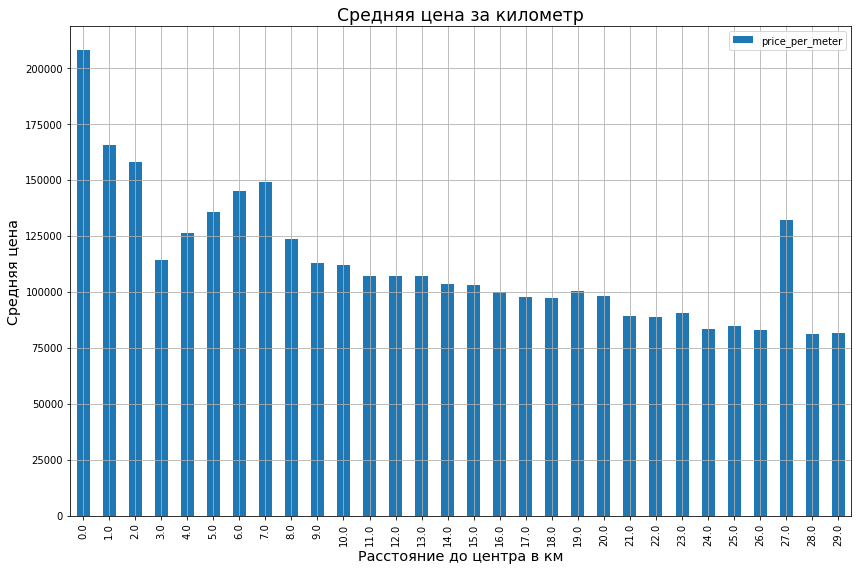

In [32]:
price_per_km = df_new.query('locality_name=="Санкт-Петербург"').pivot_table(index = 'cityCenters_nearest_round',
                                                                            values = 'price_per_meter',
                                                                            aggfunc = 'mean')
price_per_km_graphic = price_per_km.plot(kind = 'bar', figsize = (14,9), grid = True, legend = True);
plt.title('Средняя цена за километр', fontsize = 'xx-large')
plt.xlabel('Расстояние до центра в км', fontsize = 'x-large')
plt.ylabel('Средняя цена', fontsize = 'x-large')

Наблюдается резкое падение цен у трех км, дальше снова идет повышение (что-то странное находится на 3 км, но для центра как-то мало).   
Будем считать радиус центральной зоны 9 км.   
Выделю таблицу с объявлениями в центре.

In [33]:
city_center_data = df_new.query('cityCenters_nearest_round < 9')

### Анализ квартир в центре

<a name="3"></a>

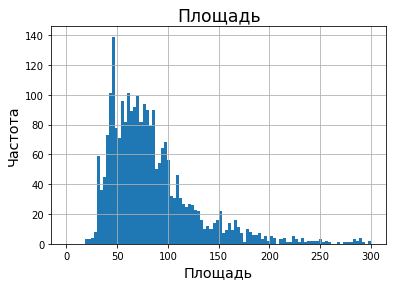

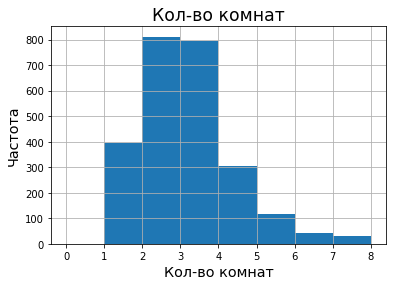

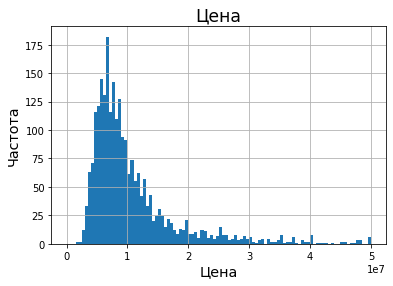

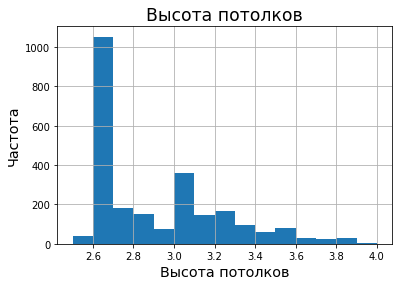

In [34]:
city_center_data_bins = [100, 8, 100, 15]
city_center_data_bins_titles = ['Площадь', 'Кол-во комнат', 'Цена', 'Высота потолков']
city_center_data_bins_ranges = [(0,300), (0,8), (0,5*10**7), (2.5,4)]
city_center_columns = ['total_area', 'rooms', 'last_price', 'ceiling_height']
city_center_data_main = []
i = 0
for row in city_center_columns:
    l = city_center_data[row].plot(kind = 'hist',
                               bins = city_center_data_bins[i],
                               grid = True, range = city_center_data_bins_ranges[i])
    city_center_data_main.append(l)
    plt.title(city_center_data_bins_titles[i], fontsize = 'xx-large')
    plt.xlabel(city_center_data_bins_titles[i], fontsize = 'x-large')
    plt.ylabel('Частота', fontsize = 'x-large')
    plt.show()
    i += 1

Анализируя графики, можно сделать следующие выводы:  
1) квартир прощадью до 50 кв. м намного меньше в центре: преобладает диапазон от 50 до 100 кв. м;  
2) квартиры в центре стоят дороже: в среднем около 6 млн руб.;  
3) в центре меньше однокомнатных, преобладают двух- и трехкомнатные квартиры;  
4) распределение высот потолков одинаковое (но высотой 3 м выделяются заметнее).

<a name="4"></a>

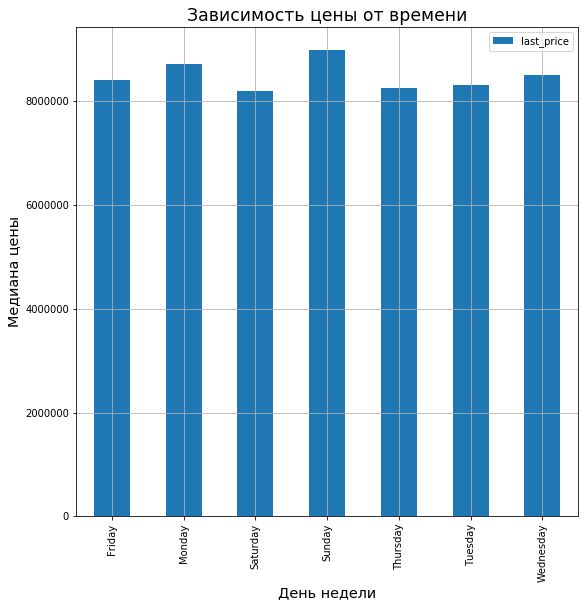

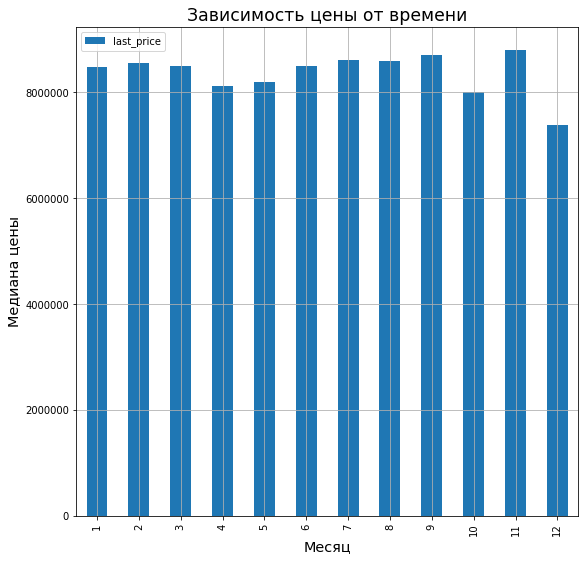

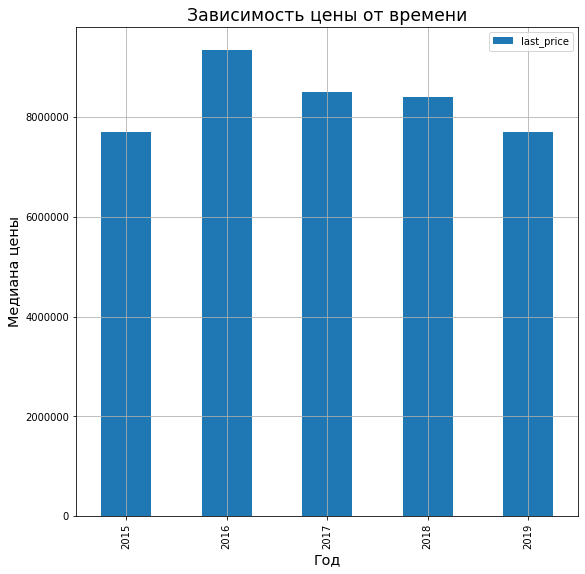

In [35]:
city_center_columns = ['day_of_week_name', 'month', 'year']
city_center_date_analysis = []
xlabels = ['День недели','Месяц','Год']
i = 0
for row in city_center_columns:
    city_center_data_cycle = city_center_data.pivot_table(index = row, values = 'last_price', aggfunc = 'median')
    k = city_center_data_cycle.plot(kind = 'bar', grid = True, figsize = (9,9));
    #plt.ylim(0,10000000)
    plt.xlabel(xlabels[i], fontsize = 'x-large')
    plt.ylabel('Медиана цены', fontsize = 'x-large')
    plt.title('Зависимость цены от времени', fontsize = 'xx-large')
    city_center_date_analysis.append(k)
    i += 1

Сильного различия в днях и месяцах не замечаю (кроме декабря и ноября, но это не играет большой роли).    
Разница в годах кардинально отличается.   
Цена на недвижимость с годами падает, 2016 год был самый выгодный.

In [36]:
city_center_data_corr = city_center_data.loc[:,['last_price','total_area','rooms',
                                                'cityCenters_nearest','ceiling_height']]
city_center_data_corr.corr()

,last_price,total_area,rooms,cityCenters_nearest,ceiling_height
last_price,1.000000,0.650969,0.349901,-0.092931,0.134323
total_area,0.650969,1.000000,0.768484,-0.156295,0.241574
rooms,0.349901,0.768484,1.000000,-0.215563,0.244651
cityCenters_nearest,-0.092931,-0.156295,-0.215563,1.000000,-0.230732
ceiling_height,0.134323,0.241574,0.244651,-0.230732,1.000000


В этом случае влияние удаленности от центра можно уже не учитывать.    
В остальном основные параметры ценообразования остаются теми же.

### Шаг 5. Общий вывод

При первоначальной обработке данных (удаление и замена пропусков) я нашел проблему в программе, определяющую расстояние до центра и остальные географические параметры. 

In [37]:
sd.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22,20,5000000.0,58.0,2017-04-24T00:00:00,2,2.75,25.0,30.0,15,False,False,False,11.0,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
333,10,5800000.0,57.0,2017-08-30T00:00:00,2,2.76,18.0,29.0,3,False,False,False,13.0,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,122.0
615,15,4100000.0,43.0,2017-06-30T00:00:00,1,2.65,18.0,10.0,12,False,False,False,20.0,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,18.0
631,6,4990000.0,55.0,2016-08-08T00:00:00,2,2.65,16.0,32.0,15,False,False,False,11.0,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,557.0
685,7,2800000.0,33.0,2016-01-11T00:00:00,1,2.55,27.0,16.0,1,False,False,False,8.4,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,303.0


В некоторых столбцах заполнил пропущенные данные (balcony=0, is_apartment = False).   
Отфильтровав таблицу, поменяли тип данных в некоторых столбцах.    
В следующем шаге добавил день недели, месяц, год, тип этажа, отношение жилой и кухонной площади к общей.   
Получена такая таблица:

In [38]:
df_to_end.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week,day_of_week_name,month,year,floor_type,living_to_total,kitchen_to_total
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1.0,482,2,755,NaN,120370.370370,7,Thursday,3,2019,Другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0,82920.792079,4,Tuesday,12,2018,Первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1.0,90,2,574,558.0,92785.714286,20,Thursday,8,2015,Другой,0.612500,0.148214
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0,100000.000000,19,Tuesday,6,2018,Другой,0.320000,0.410000
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474,10,Monday,9,2018,Другой,0.473684,0.299342


Изучена зависимость цены от основных параметров и выяснено, что цена больше зависит от общей площади, чем от удаленности от центра

Выяснено, что цена не зависит от дня публикации объявления, а также от месяца (полагаю, что различие имеет случайный характер).     
Однако цена зависит от года, и в последние два года она растет.   
Получен и отсортирован по цене за квадратный метр список 10 самых популярных населенных пунктов по продажам.

In [39]:
top_ten_end

,price_per_meter
locality_name,
Санкт-Петербург,112575.541527
Пушкин,103474.946140
деревня Кудрово,92275.248321
посёлок Парголово,89911.995183
посёлок Мурино,85560.730112
Петергоф,83388.274773
посёлок Шушары,77771.925501
Колпино,74740.505600
Всеволожск,69444.491372


Выявлен сегмент квартир в центре и проведен аналогичный анализ.
Я выяснил, что несмотря на то, что квартиры в центре, разумеется, стоят дороже, наблюдается тенденция падения цен на эти квартиры и тенденция роста цен на недвижимость за пределами центра.